In [1]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [3]:
project_name = 'course-project-assignment-4'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
data_file = '../input/gender-classification-dataset'

print(os.listdir(data_file))
classes = os.listdir(data_file)
print(classes)

['Validation', 'Training']
['Validation', 'Training']


In [6]:
female_train_files = os.listdir(data_file + "/Training/female")
print("test examples for female:", len(female_train_files))
print(female_train_files[:4])

test examples for female: 23243
['139129.jpg.jpg', '165249.jpg.jpg', '131915.jpg.jpg', '190023.jpg.jpg']


In [7]:
dataset_train = ImageFolder(data_file+"/Training", transform=ToTensor())
len(dataset_train)

47009

In [8]:
im_count = 0
for image,_ in dataset_train:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break

torch.Size([3, 114, 92])
torch.Size([3, 110, 88])
torch.Size([3, 100, 80])
torch.Size([3, 102, 85])
torch.Size([3, 107, 86])
torch.Size([3, 102, 79])
torch.Size([3, 104, 89])
torch.Size([3, 99, 78])
torch.Size([3, 98, 76])
torch.Size([3, 118, 84])


In [9]:
dataset_train.classes

['female', 'male']

In [10]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])
dataset_train = ImageFolder(data_file+"/Training", transform = transform)
dataset_val = ImageFolder(data_file+"/Validation", transform = transform)

In [11]:
im_count = 0
for image,_ in dataset_train:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break  


torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


In [12]:
img, label = dataset_train[2500]
print(img.shape, label)

torch.Size([3, 100, 100]) 0


In [13]:
def show_example(img,label):
  print('Label: ', classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))

Label:  Training (1)


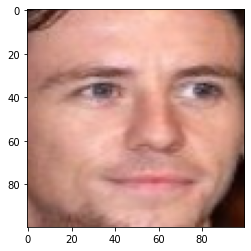

In [14]:
show_example(*dataset_train[41529])

In [15]:
import jovian
jovian.commit(project = project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/vardhanyash20000/course-project-assignment-4


<IPython.core.display.Javascript object>

TRAINING

In [16]:
random_seed = 0
torch.manual_seed(random_seed)

len(dataset_train)


47009

In [17]:
len(dataset_val)

11649

In [18]:
train_size = 30000
val_size = len(dataset_train) - train_size

data_train, data_val = random_split(dataset_train, [train_size, val_size])
len(data_train), len(data_val)

(30000, 17009)

In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [20]:
train_dl = DataLoader(data_train, batch_size, shuffle = True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(data_val, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(dataset_val, batch_size*2, num_workers=4, pin_memory=True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
  for img, label in dl:
    fig, ax = plt.subplots(figsize = (16, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrow = 16).permute(1,2,0))
    break

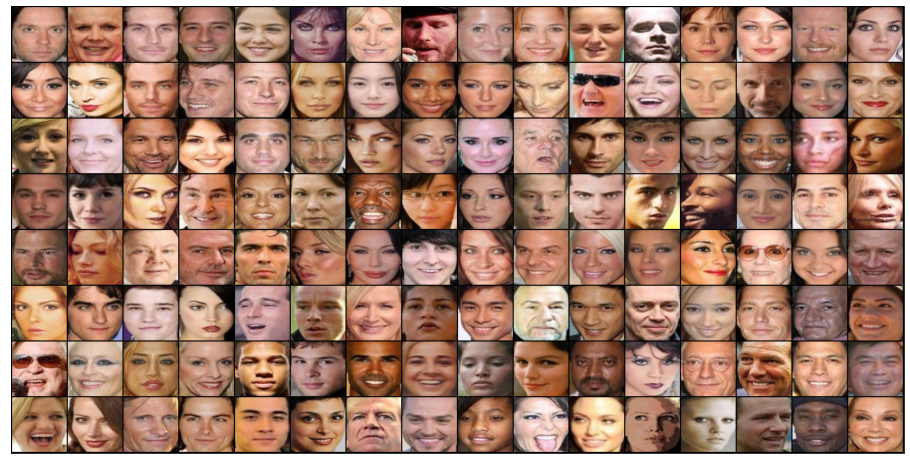

In [22]:
show_batch(train_dl)

In [23]:

jovian.commit(project = project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/vardhanyash20000/course-project-assignment-4


<IPython.core.display.Javascript object>

MODEL

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
sample_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2)
)


In [26]:
for images, labels in train_dl:
    print("images shape: ", images.shape)
    out = sample_model(images)
    print("out shape", out.shape)
    break

images shape:  torch.Size([128, 3, 100, 100])
out shape torch.Size([128, 32, 50, 50])


In [27]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class GenCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 64 x 50 x 50
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 128 x 25 x 25
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 256 x 12 x 12
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 512 x 6 x 6
            
            nn.Flatten(),
            nn.Linear(512*6*6, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [29]:
model = GenCnnModel()
model

GenCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [30]:
for images, labels in train_dl:
    print("images shape: ", images.shape)
    out = model(images)
    print("out shape: ", out.shape)
    print("out[0]: ", out[0])
    break

images shape:  torch.Size([128, 3, 100, 100])
out shape:  torch.Size([128, 2])
out[0]:  tensor([-0.2043, -0.1061], grad_fn=<SelectBackward>)


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [32]:
def to_device(data, device):
   
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [33]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
test_loader = DeviceDataLoader(test_dl, device)
to_device(model, device);

MODEL TRAINING

In [34]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
model = to_device(GenCnnModel(), device)
model

GenCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [36]:
evaluate(model, val_loader)

{'val_loss': 0.6942011117935181, 'val_acc': 0.4973531663417816}

In [37]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [38]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [39]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.6581, val_loss: 0.4951, val_acc: 0.7636
Epoch [1], train_loss: 0.3010, val_loss: 0.1766, val_acc: 0.9362
Epoch [2], train_loss: 0.1721, val_loss: 0.1431, val_acc: 0.9465
Epoch [3], train_loss: 0.1419, val_loss: 0.1246, val_acc: 0.9572
Epoch [4], train_loss: 0.1226, val_loss: 0.1306, val_acc: 0.9518


In [40]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


In [41]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

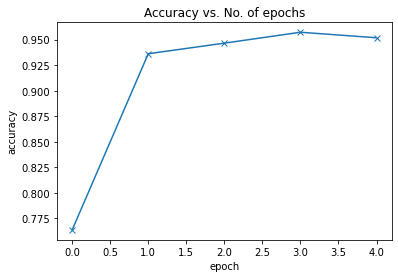

In [43]:
plot_accuracies(history)

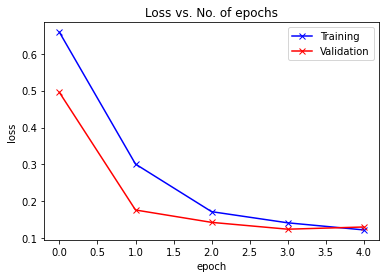

In [44]:
plot_losses(history)

In [45]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/vardhanyash20000/course-project-assignment-4


<IPython.core.display.Javascript object>